<a href="https://colab.research.google.com/github/paul028/myJupyterNotebook/blob/master/Cifar10_MLP_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Image Classifier based on CIFAR10 Dataset using Multilayer Perceptron Neural Network**


1. Import all the Necessary Libraries

In [0]:
#!pip3 install livelossplot
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from scipy.misc import toimage
import os

2. Call the Address of the TPU

In [0]:
# This address identifies the TPU we'll use when configuring TensorFlow.
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
tf.logging.set_verbosity(tf.logging.INFO)

3. Prepare the Dataset

In [0]:
#load CIFAR10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# one-hot encode the labels
num_labels = len(np.unique(y_train))

#convert to one-hot vector
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
    
# image dimensions (assumed square)
image_size = x_train.shape[1]
input_size = image_size * image_size

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# rescale [0,255] --> [0,1]
# resize and normalize
#x_train = np.reshape(x_train, [-1, input_size*3])
#x_train = x_train.astype('float32') / 255
#x_test = np.reshape(x_test, [-1, input_size*3])
#x_test = x_test.astype('float32') / 255


# print shape of training set
print('x_train shape:', x_train.shape)
# print number of training, validation, and test images
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170500096/170498071 [==============================] - 37s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


4. Dataset Augmentation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  del sys.path[0]


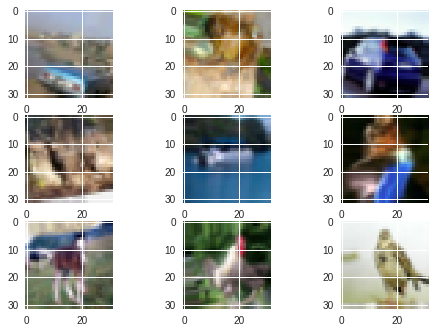

In [0]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=128):
    # Show 9 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(toimage(X_batch[i].reshape(32, 32, 3)))
    # show the plot
    plt.show()
    break

5. Initialize the Parameters

In [0]:
batch_size = 128 #128
hidden_units = 1024
dropout = 0.2
weight_decay = 1e-4

6. Prepare the Model

In [0]:
model = Sequential()

model.add(Flatten(input_shape = x_train.shape[1:]))
#3 Hidden Layer MLP with Batch Normalization and Dropout
model.add(Dense(hidden_units,kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(hidden_units, kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(hidden_units,kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

#output layer
model.add(Dense(num_labels))
model.add(Activation('softmax')) 

model.summary()
plot_model(model,to_file='mlp-CIFAR10.png',show_shapes=True)

opt_rms = tf.keras.optimizers.RMSprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy',optimizer=opt_rms,metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              3146752   
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)      

7. Define a Function for Changing Learning Rate

In [0]:

def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

8. convert the keras model to TPU model

In [0]:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
model,
strategy=tf.contrib.tpu.TPUDistributionStrategy(
    tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.67.212.154:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 8969509305344894914)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 6048440157279187185)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 6377082180396626634)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1

9. Train the Network

In [0]:
history =tpu_model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=125,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule)])

#print(history)

Epoch 1/125
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(16,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(16, 32, 32, 3), dtype=tf.float32, name='flatten_input_10'), TensorSpec(shape=(16, 10), dtype=tf.float32, name='activation_3_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning RMSprop {'lr': 0.0010000000474974513, 'rho': 0.8999999761581421, 'decay': 9.999999974752427e-07, 'epsilon': 1e-07}
INFO:tensorflow:Remapping placeholder for flatten_input
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.RMSprop object at 0x7fe798137828> []
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 4.189309120178223 secs
INFO:tensorflow:Setting weights on TPU model.
INFO:tensorflow:CPU -> TPU lr: 0.0010000000474974513 {0.001}
INFO:tensorflow:CPU -> TPU rho: 0.8999

10. Testing

In [0]:


scores = tpu_model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print("\nTest result: %.3f loss: %.3f" % (scores[1]*100,scores[0]))


10000/10000 [==============================] - 1s 110us/sample - loss: 1.3596 - acc: 0.5416

Test result: 54.160 loss: 1.360
